In [1]:
!pip install pandas scikit-learn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import IsolationForest

## 1. Load the dataset

In [3]:
file_path = "../binance-dataset-extract/1INCH-BTC.parquet"
df = pd.read_parquet(file_path)

# Display the first few rows of the dataset
df.head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2020-12-25 05:00:00,0.000009,0.000168,0.000009,0.000106,121635.101562,13.708220,561,39139.000000,4.596730
2020-12-25 05:01:00,0.000106,0.000113,0.000091,0.000101,68514.296875,6.990613,523,10134.000000,1.031620
2020-12-25 05:02:00,0.000102,0.000118,0.000101,0.000115,58331.500000,6.432216,414,7388.600098,0.801500
2020-12-25 05:03:00,0.000114,0.000140,0.000108,0.000112,81144.398438,9.602539,553,40707.101562,5.047240
2020-12-25 05:04:00,0.000112,0.000114,0.000107,0.000108,33466.800781,3.697582,309,11160.799805,1.232953


## 2. Data Overview and Exploration
 We will now check the basic structure, data types, and perform some initial exploration.

In [4]:
# Check the data types of each column
df.dtypes

open                            float32
high                            float32
low                             float32
close                           float32
volume                          float32
quote_asset_volume              float32
number_of_trades                 uint16
taker_buy_base_asset_volume     float32
taker_buy_quote_asset_volume    float32
dtype: object

In [5]:
# Get a summary of missing values
df.isna().sum()

open                            0
high                            0
low                             0
close                           0
volume                          0
quote_asset_volume              0
number_of_trades                0
taker_buy_base_asset_volume     0
taker_buy_quote_asset_volume    0
dtype: int64

In [6]:
# Basic descriptive statistics
df.describe()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
count,995183.000000,995183.000000,995183.000000,995183.000000,995183.000000,995183.000000,995183.000000,995183.000000,995183.000000
mean,0.000056,0.000056,0.000056,0.000056,1033.874756,0.074398,9.752455,511.082062,0.036704
std,0.000025,0.000025,0.000025,0.000025,4263.422363,0.357423,31.330643,2478.302002,0.206434
min,0.000009,0.000024,0.000009,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000033,0.000033,0.000033,0.000033,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000052,0.000052,0.000052,0.000052,90.599998,0.004622,3.000000,14.000000,0.000774
75%,0.000072,0.000072,0.000072,0.000072,580.500000,0.033758,9.000000,201.800003,0.011898
max,0.000167,0.000168,0.000166,0.000167,565528.625000,65.059418,6643.000000,424497.000000,50.854492


## 3. Visualize the Data

We'll now visualize some of the key columns to understand the time-series patterns.

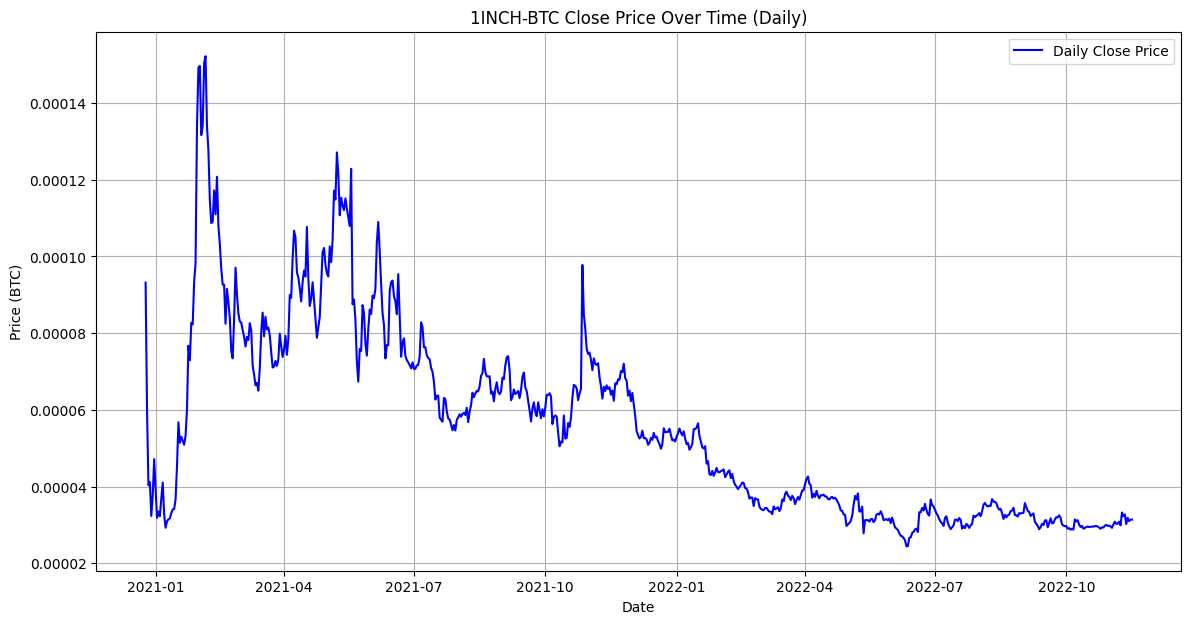

In [7]:
# Resample data to daily frequency to analyze long-term trends
df_daily = df.resample('D').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last',
    'volume': 'sum',
    'number_of_trades': 'sum'
})

# Visualize Daily Close Price
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['close'], label='Daily Close Price', color='blue')
plt.title('1INCH-BTC Close Price Over Time (Daily)')
plt.xlabel('Date')
plt.ylabel('Price (BTC)')
plt.legend()
plt.grid(True)
plt.show()

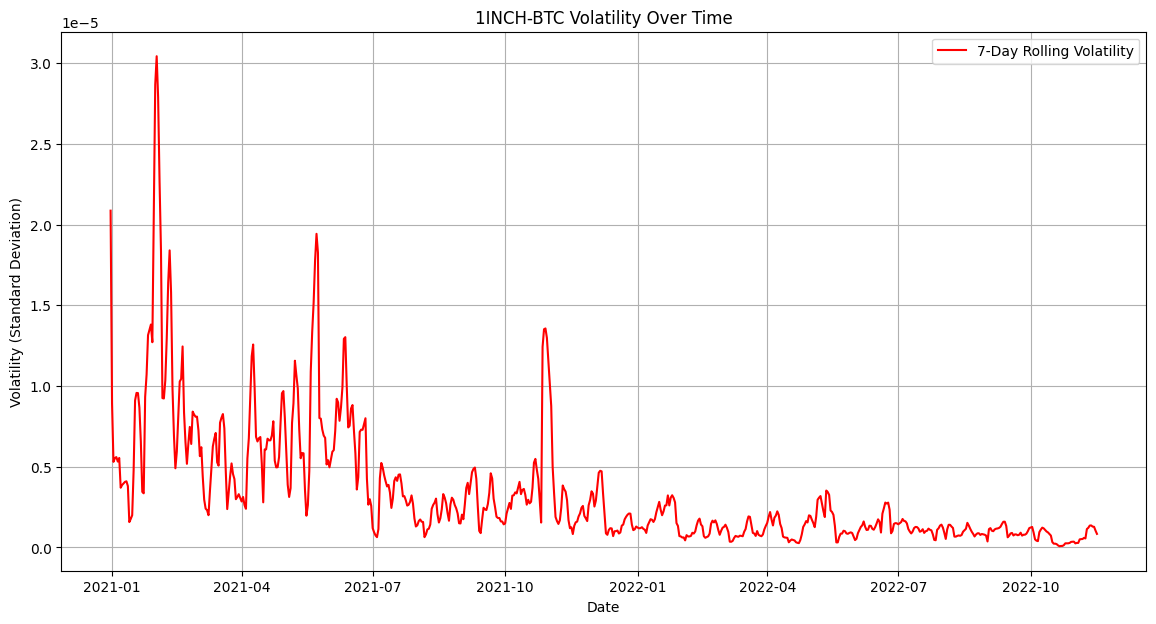

In [8]:
# Calculate Rolling Volatility (Standard Deviation of Closing Prices)
df_daily['volatility'] = df_daily['close'].rolling(window=7).std()

# Plot Volatility Over Time
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['volatility'], label='7-Day Rolling Volatility', color='red')
plt.title('1INCH-BTC Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Standard Deviation)')
plt.legend()
plt.grid(True)
plt.show()

## Logarithmic Returns Calculation

Logarithmic returns allow us to assess price movements proportionally, which is useful for financial data.

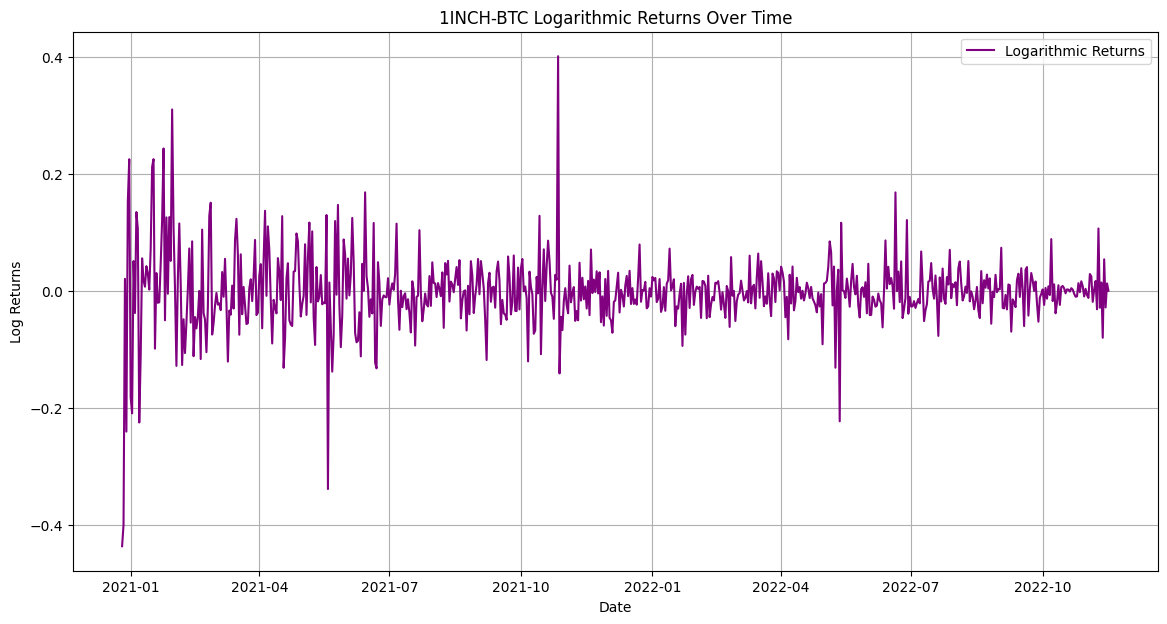

In [9]:
# Calculate Logarithmic Returns
df_daily['log_returns'] = np.log(df_daily['close'] / df_daily['close'].shift(1))

# Plot Logarithmic Returns
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['log_returns'], label='Logarithmic Returns', color='purple')
plt.title('1INCH-BTC Logarithmic Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Log Returns')
plt.legend()
plt.grid(True)
plt.show()

### Moving Averages (SMA)

Moving averages smooth out short-term fluctuations and highlight longer-term trends.

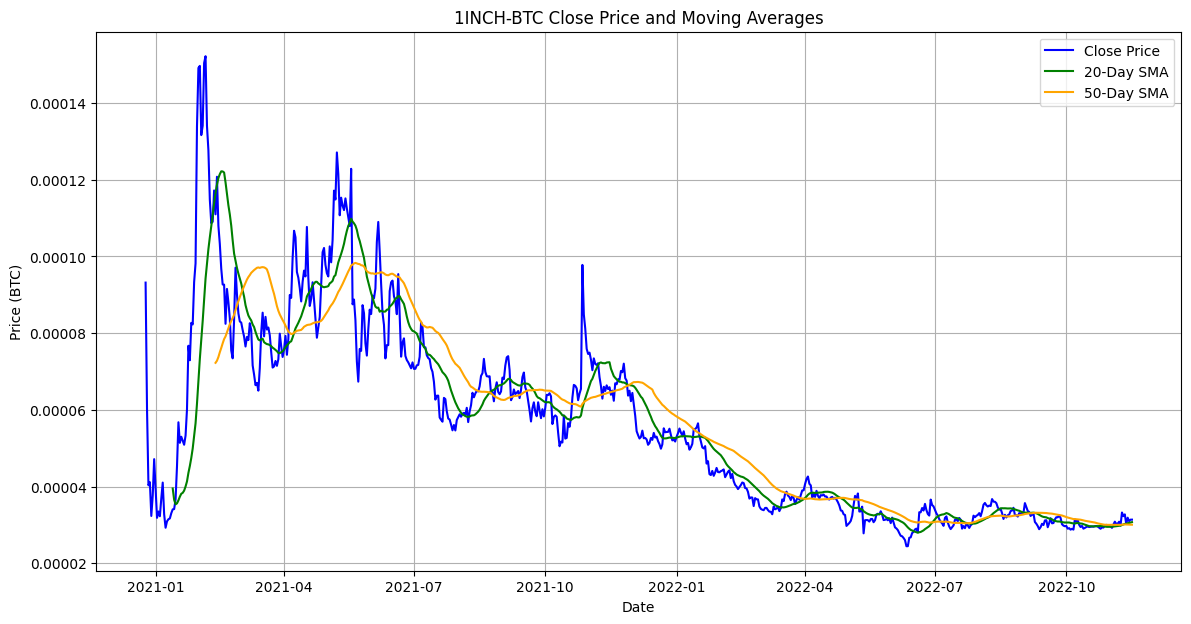

In [10]:
# Calculate Simple Moving Averages (SMA)
df_daily['SMA_20'] = df_daily['close'].rolling(window=20).mean()  # 20-day MA
df_daily['SMA_50'] = df_daily['close'].rolling(window=50).mean()  # 50-day MA

# Plot Moving Averages with Close Price
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['close'], label='Close Price', color='blue')
plt.plot(df_daily.index, df_daily['SMA_20'], label='20-Day SMA', color='green')
plt.plot(df_daily.index, df_daily['SMA_50'], label='50-Day SMA', color='orange')
plt.title('1INCH-BTC Close Price and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (BTC)')
plt.legend()
plt.grid(True)
plt.show()

### RSI (Relative Strength Index)

RSI is a momentum indicator used in technical analysis, which helps identify overbought or oversold conditions in the market.

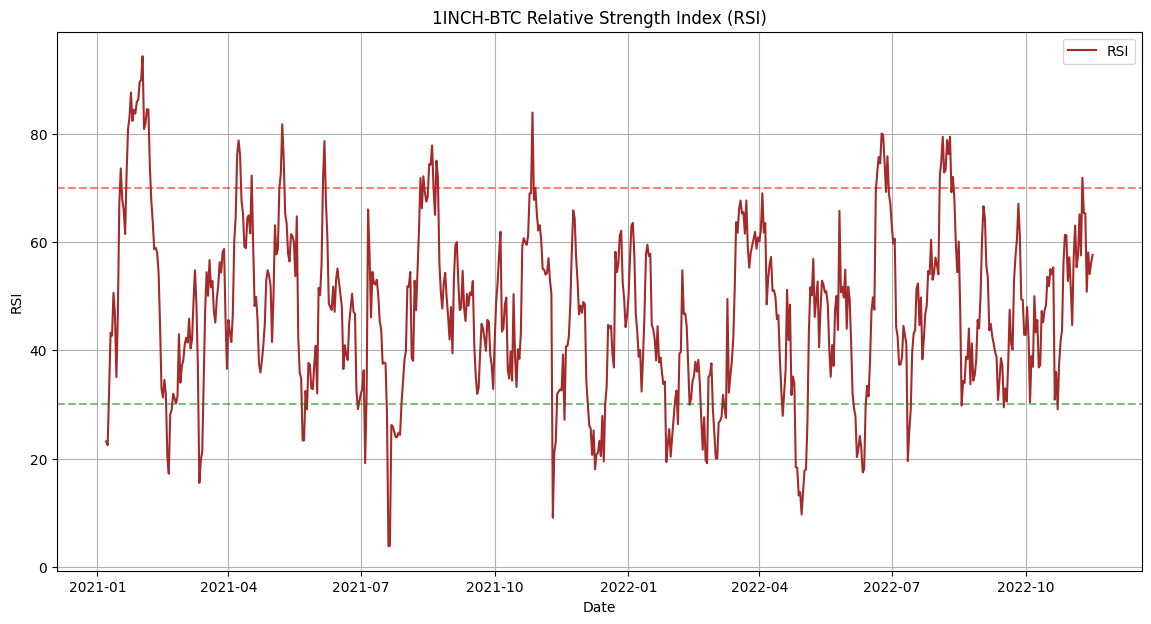

In [11]:
# Calculate RSI
delta = df_daily['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()

rs = avg_gain / avg_loss
df_daily['RSI'] = 100 - (100 / (1 + rs))

# Plot RSI
plt.figure(figsize=(14, 7))
plt.plot(df_daily.index, df_daily['RSI'], label='RSI', color='brown')
plt.axhline(70, linestyle='--', alpha=0.5, color='red')  # Overbought line
plt.axhline(30, linestyle='--', alpha=0.5, color='green')  # Oversold line
plt.title('1INCH-BTC Relative Strength Index (RSI)')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.show()

### Trade Volume Analysis

Analyze the trade volume to see how much activity there was in the market over time.

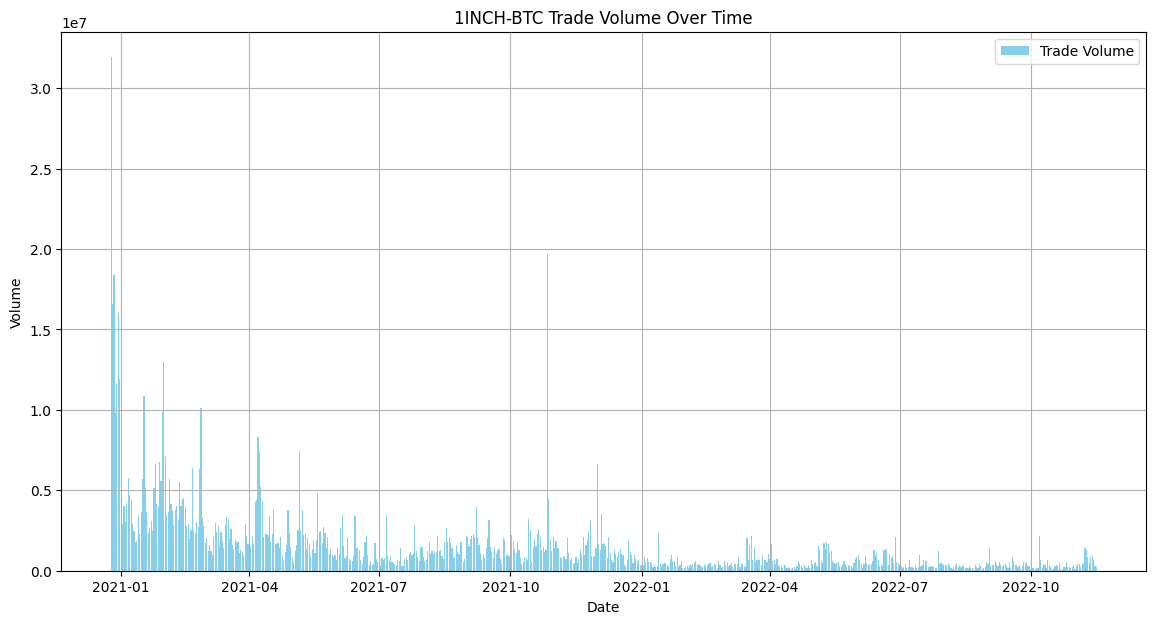

In [12]:
# Plot Trade Volume Over Time
plt.figure(figsize=(14, 7))
plt.bar(df_daily.index, df_daily['volume'], label='Trade Volume', color='skyblue')
plt.title('1INCH-BTC Trade Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

### Feature Correlations and Heatmap

Calculate the correlation between various features to understand their relationships.

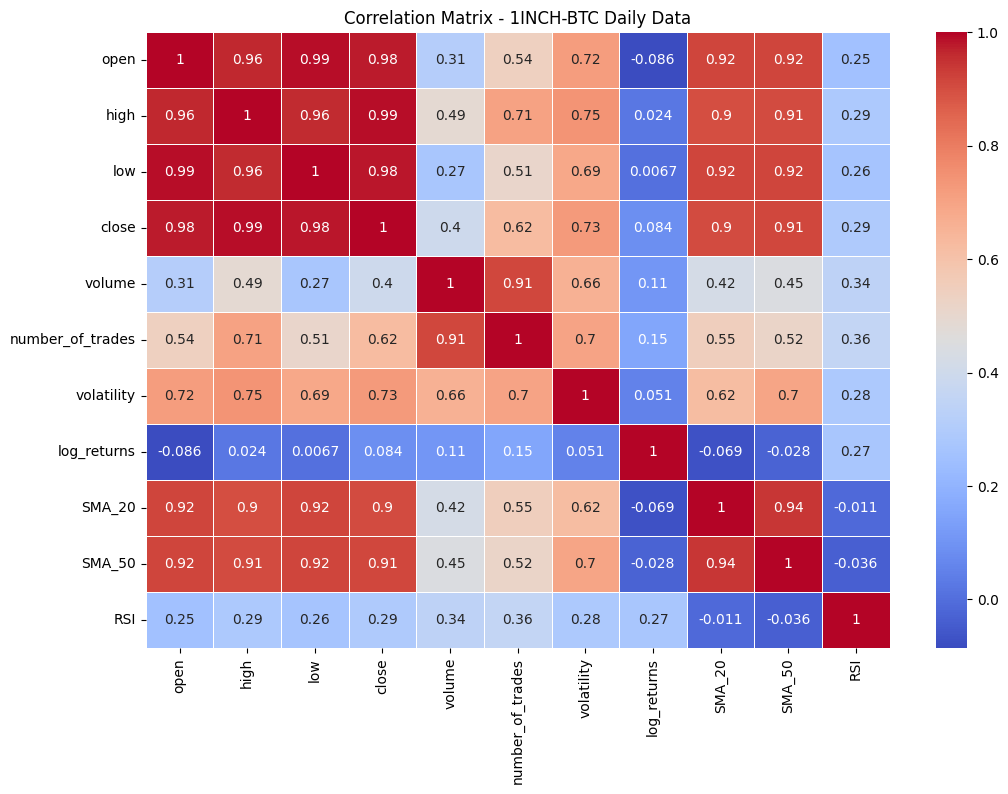

In [13]:
# Calculate and Visualize the Correlation Matrix
corr_matrix = df_daily.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix - 1INCH-BTC Daily Data')
plt.show()

In [15]:
# Save df_daily using pickle
df_daily.to_csv('../binance-dataset-extract/df_daily.csv')